In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


%matplotlib inline

## Overview of the AirBNB data 

The data from AirBNB Seattle consist of 3 dataframes:

* Listings: There are 92 features with 3818 datapoints
* Calendar: We have 4 features with 1393570 datapoints
* Reviews: There are 6 features with 84849 datapoints

In [70]:
listings = pd.read_csv("./archive/listings.csv", header=0)
calendar = pd.read_csv("./archive/calendar.csv", header=0)
reviews = pd.read_csv("./archive/reviews.csv", header=0)

In [71]:
print("Listings: ", listings.shape)
print("Calendar: ", calendar.shape)
print("Reviews: ", reviews.shape)

Listings:  (3818, 92)
Calendar:  (1393570, 4)
Reviews:  (84849, 6)


## Part 1: Is the daily price shown in the AirBNB data dependent on the different neighbourhoods of Seattle or not?

For the first part we want to focus onto the **'listings'**-dataframe. As a first step we want to analyse if the daily prices within the different areas of Seattle are comparable and have almost the same distribution or if we observe differences related to those groups.

As a guideline we therefore do the following steps:
1. *Data-Cleaning:* Eliminating (from the author's view) unnecessary features
2. *Data-Cleaning:* Convert the dtype of price from 'object' into a 'float64'
3. *Analyzing:* Calculating the mean and standard deviation of the price dependend to each area (neighbourhood group)
4. *Visualization:* Creating a boxplot of the prices dependent on the different areas (neighbourhood groups) in Seattle
5. *Modelling:* Finalising the result with a one-way ANOVA


In [72]:
# 1. Data Cleaning: Elimination of unnecessary features (author's decision)

# The author's decision to eliminate certain features was guided on the one hand from a logical point of relevance, 
# i.e. an 'url' has no meaning related to a price, and on the other hand from rationality, i.e. latitude or longitude are too particular to
# generalise well onto new unseen data.

# But there exist debatable features like i.e. 'license' or i.e. 'has_picture' which could have potential predictive power, but is 
# left out for further inspection.

# The author eleimiates the following features from the original dataset:

labels = ["last_scraped", "experiences_offered", "scrape_id", "listing_url", "neighborhood_overview", "notes", "transit", "thumbnail_url",
"medium_url", "picture_url", "xl_picture_url", "host_url", "host_about", "host_thumbnail_url", "host_picture_url", "host_listings_count",
"street", "neighbourhood", "country_code", "city", "state", "market", "smart_location", "square_feet", "has_availability", "availability_30",
"availability_60", "availability_90", "availability_365", "calendar_last_scraped", "first_review", "last_review", "requires_license", 
"license", "jurisdiction_names", "name", "summary", "space", "description", "host_location", "host_neighbourhood", "country", "latitude",
"longitude", "is_location_exact", "host_name", "host_is_superhost"]
listings_reduced = listings.drop(labels=labels, axis=1)

In [73]:
###################################
###################################
### Delete

#listings1.to_csv("./archive/listings1.csv")
#test = listings1.groupby("neighbourhood_group_cleansed").count()
#pair_t = mod.t_test_pairwise('neighbourhood_group_cleansed')
#pp = pair_t.result_frame
#pp.to_csv("./archive/pp.csv")
#plt.figure(figsize=(15,8))
#listings1.hist();

In [74]:
# 2. Data Cleaning: Change dtype of column 'price' from 'object'-type to 'float64'-type

# At this point we need to transform the price feature to a dtype 'float64'. This is easy done with a tiny regex:

listings_reduced['price'].replace(to_replace=r'[\$,]', value='', inplace=True, regex=True)
listings_reduced['price'] = listings_reduced['price'].astype('float64')
listings_reduced['price'].dtypes

dtype('float64')

In [75]:
# 3. Analyzing: Calculating the mean of the price dependent on the area of Seattle

# As a first insight we calculacte the 'mean'-Value of the prices for each neighbourhood we have in the dataset. As a result we identify higher
# mean prices around 177 USD per day in Magnolia and lower mean prices per day with around 83 USD in Delrigde.

# As a side effect we get to know the different neighbourhood groups in the dataset. It seems that smaller neighbourhoods are summarized in the 
# neighbourhood 'Other neighbourhoods'. 

listings_reduced.groupby("neighbourhood_group_cleansed").mean()['price'].sort_values(ascending=False)

neighbourhood_group_cleansed
Magnolia               177.672131
Queen Anne             157.223729
Downtown               154.405660
West Seattle           141.359606
Cascade                140.101124
Capitol Hill           130.592593
Central Area           128.338753
Ballard                124.682609
Other neighborhoods    119.968514
Interbay               109.727273
Seward Park            108.477273
Beacon Hill             94.669492
University District     93.639344
Lake City               92.671642
Rainier Valley          91.899371
Northgate               88.550000
Delridge                83.278481
Name: price, dtype: float64

In [76]:
# 3. Analyzing: Calculating the standard deviation of the price dependent on the area of Seattle

# As a next step it would be interesting to have information about the spreading of the prices in each neighbourhood group, therefore
# we calculate the standard deviation for each group. As a result we have those groups with higher prices also do have a higher standard
# deviation like 'Magnolia' and 'Queen Anne' and those groups with smaller mean price also do have smaller standard deviation like 'Northgate'
# and 'Delridge'.

# As a first impression one could conclude that there are major differences within the different neighbourhood groups.

listings_reduced.groupby("neighbourhood_group_cleansed").std()['price'].sort_values(ascending=False)

neighbourhood_group_cleansed
Magnolia               150.078726
Queen Anne             115.863385
Cascade                112.179042
Capitol Hill            92.442331
Downtown                90.902800
West Seattle            89.147801
Ballard                 87.925033
Other neighborhoods     86.580450
Central Area            80.260558
Seward Park             71.718276
Beacon Hill             61.528682
Interbay                60.003485
University District     59.721816
Lake City               57.212625
Rainier Valley          52.505599
Delridge                41.797110
Northgate               38.642110
Name: price, dtype: float64

Text(0, 0.5, 'Neighbourhoods')

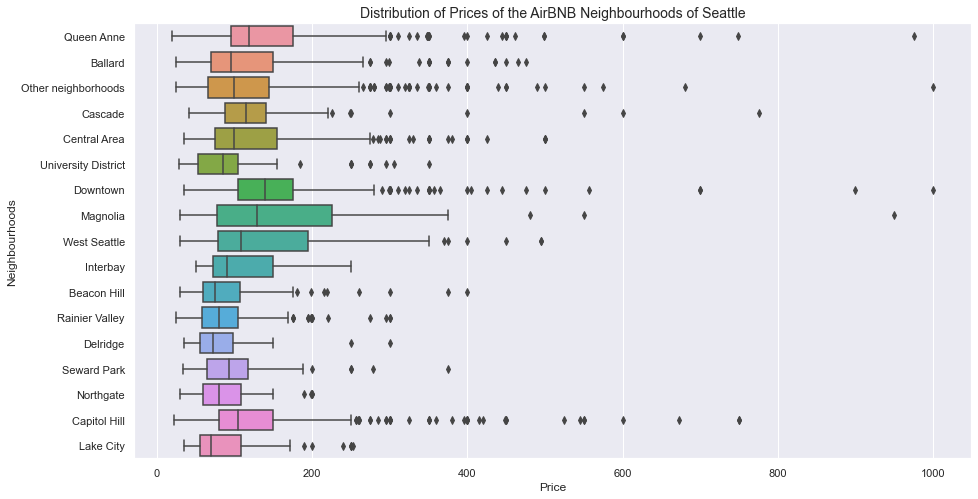

In [77]:
# 4. Visualization: Boxplot of the prices related to the different areas of Seattle

# To support the first impression we show a boxplot of the prices in each neighbourhood group. A visual 
# inspection also supports the impression we do have, the prices in the neighbourhoods 'Magnolia' or 'Queen Anne' 
# seem to be different than those within the neighbourhoods i.e. in 'Delridge' or 'Northgate'.

sns.set(rc = {'figure.figsize':(15,8)})
boxplot = sns.boxplot(x='price', y='neighbourhood_group_cleansed', data=listings_reduced)
boxplot.axes.set_title("Distribution of Prices of the AirBNB Neighbourhoods of Seattle", fontsize=14)
boxplot.set_xlabel("Price")
boxplot.set_ylabel("Neighbourhoods")


In [78]:
# 5. Modelling & Evaluation: One-way ANOVA

# As last step we model the prices with a linear One-way Anova and analyze the variance due to each neighbourhood group:

mod = ols('price ~ neighbourhood_group_cleansed', data=listings_reduced).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
neighbourhood_group_cleansed,1.747772e+06,16.0,14.150561,5.984737e-38
Residual,2.934195e+07,3801.0,NaN,NaN


In [ ]:
# 5. Modelling & Evaluation: One-way ANOVA

# The Anova result is significant, therefore we can assume that the visual impressions are valid
# and that the prices depend on the different neighbourhood groups.

## Part 2: Price prediction

For the price prediction we consider a linear regression model where we preselect (author's judgement due to a corrleation analyses) features.

We therefore have the following guidline:
1. *Analyzing/ Visualization:* Correlation of the different features in the data.
2. *Modelling:* Selection of qualified features
3. *Data-Cleaning:* Data preparation: Handling of missing values.
4. *Data-Cleaning:* Data preparation: Handling of categorical variables.
5. *Modelling & Evaluation:* Linear regression

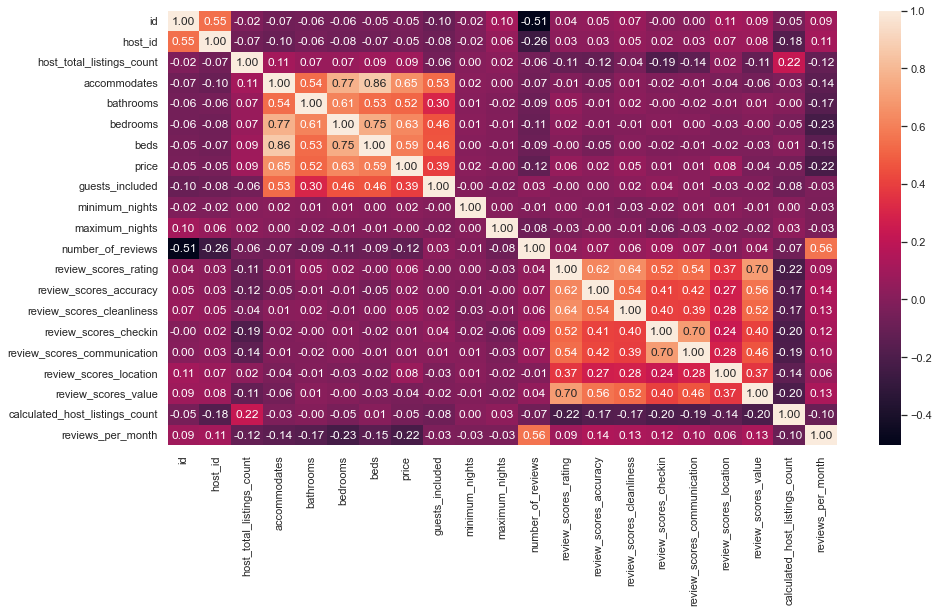

In [79]:
# 1. Analyzing/ Visualization: Correlation matrix of the different quantitative features of the data set
sns.heatmap(listings_reduced.corr(), annot=True, fmt=".2f");

In [148]:
# 2. Modelling: Selection of qualified features. 

# - In Part 1 we analysed that the neighbourhood has statistically an influence on the prices, so that we include this categorical feature.
# - Analysing the correlation matrix we identify a lot of uncorrelated variables but also two clusters of features positive correlated variables:
#
#       One cluster ist centered around the reviews. For the price prediction we only consider taking into account the 'reviews_per_month' variable
#       which is slightly negative correlated with the price variable.
#       
#       The other cluster is centered around the variables of capacity of the apartment/ house. Here we take into account some variables 
#       where we see a high correlation with the price variable. The highest correlation we see between 'accommodates' and 'price'. 
#
#       Due to the fact that we also see high correlation (cor >= 0.7) between 'accommodates' and 'beds' and 'bedrooms' we don't take into account
#       those latter two features so that we don't encounter multicollinearity.
# 
#       As categorical variables the author decides to take into account the in part 1 mentioned 'neighbourhood_group_cleansed', the 'bed_type'
#       and the 'cancellation_policy'

selected_features = ['price', 'accommodates', 'bathrooms', 'guests_included', 'reviews_per_month' , 'neighbourhood_group_cleansed', 'bed_type',
                     'cancellation_policy']

listings_linearmodel = listings_reduced[selected_features]
listings_linearmodel.head()

,price,accommodates,bathrooms,guests_included,reviews_per_month,neighbourhood_group_cleansed,bed_type,cancellation_policy
0,85.0,4,1.0,2,4.07,Queen Anne,Real Bed,moderate
1,150.0,4,1.0,1,1.48,Queen Anne,Real Bed,strict
2,975.0,11,4.5,10,1.15,Queen Anne,Real Bed,strict
3,100.0,3,1.0,1,NaN,Queen Anne,Real Bed,flexible
4,450.0,6,2.0,6,0.89,Queen Anne,Real Bed,strict


In [93]:
# 2. Modelling: Selection of qualified features. 
listings_linearmodel.shape

(3818, 8)

In [94]:
# 3. Data cleaning: Handling of missing values.

# We have two variables where we observe missing values. From 3818 data points we observe 16 missing values at the 'bathrooms' feature and 627
# missing values at the 'reviews_per_month' feature.

listings_linearmodel.isna().sum()

price                             0
accommodates                      0
bathrooms                        16
guests_included                   0
reviews_per_month               627
neighbourhood_group_cleansed      0
bed_type                          0
cancellation_policy               0
dtype: int64

In [149]:
# 3. Data cleaning: Handling of missing values.
# 3.1 Handling of missing values of feature 'reviews_per_month':

# The author's view is that for the feature 'reviews_per_month' we imput the value zero, because that is likely to be the closest interpretation of a
# NaN value. There just does not exist any review. In any case it does not make sense to imput the mean or mode.

listings_linearmodel.loc[: , 'reviews_per_month'] = listings_linearmodel['reviews_per_month'].fillna(value=0)

C:\Users\jh\AppData\Local\Temp\ipykernel_17888\2019607787.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_linearmodel.loc[: , 'reviews_per_month'] = listings_linearmodel['reviews_per_month'].fillna(value=0)


In [96]:
# 3. Data cleaning: Handling of missing values.
listings_linearmodel.isna().sum()

price                            0
accommodates                     0
bathrooms                       16
guests_included                  0
reviews_per_month                0
neighbourhood_group_cleansed     0
bed_type                         0
cancellation_policy              0
dtype: int64

In [150]:
# 3. Data cleaning: Handling of missing values.
# 3.2 Handling of missing values of feature 'bathrooms':

# For the feature 'bathrooms' we try to exploit the positive correlation between the feature 'accommodates' and 'bathrooms' and predict with a linear
# regression the number of bathrooms with respect to the given feature 'accommodates'.

bathrooms_preddf = listings_linearmodel[['accommodates', 'bathrooms']]
#bathrooms_preddf.dropna(inplace=True);
bathrooms_preddf = bathrooms_preddf.dropna()

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(bathrooms_preddf['accommodates'].values.reshape(-1,1), bathrooms_preddf['bathrooms'], test_size=0.3, random_state=42)

#lm_model_b = LinearRegression(normalize=True)
lm_model_b = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
lm_model_b.fit(X_train_b, y_train_b)

# We round the predictions from the linear model to next .5 according for having i.e. 4.0 or 4.5 bathrooms
predictions = np.round(lm_model_b.predict(bathrooms_preddf['accommodates'].values.reshape(-1,1)) * 2) / 2

listings_linearmodel.loc[:, 'bathrooms'] = listings_linearmodel['bathrooms'].fillna( pd.Series(predictions) )


C:\Users\jh\AppData\Local\Temp\ipykernel_17888\2011178195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_linearmodel.loc[:, 'bathrooms'] = listings_linearmodel['bathrooms'].fillna( pd.Series(predictions) )


In [151]:
# 3. Data cleaning: Handling of missing values.
#  
# There are no missing values left.
listings_linearmodel.isna().sum()

price                           0
accommodates                    0
bathrooms                       0
guests_included                 0
reviews_per_month               0
neighbourhood_group_cleansed    0
bed_type                        0
cancellation_policy             0
dtype: int64

In [99]:
# 4. Data Cleaning: Categorical Variables

# As shown within the following output the data frame we are preparing has: 
# 
# 3 features of dtype 'float64':
# - price
# - bathrooms
# - reviews_per_month
# 
# 2 features of dtype 'int64':
# - accomodates
# - guests_included
# 
# and 3 features of dtype 'object':
# - neighbourhood_group_cleansed
# - bed_type
# - cancellation_policy

listings_linearmodel.dtypes

price                           float64
accommodates                      int64
bathrooms                       float64
guests_included                   int64
reviews_per_month               float64
neighbourhood_group_cleansed     object
bed_type                         object
cancellation_policy              object
dtype: object

In [100]:
# 4. Data Cleaning: Categorical Variables

# The feature 'neighbourhood_group_cleansed' consists of 17 different groups which represent the different neighbourhoods:
listings_linearmodel['neighbourhood_group_cleansed'].astype('category').dtypes

# The feature 'bed_type' consists of the following 5 different types:
# 'Airbed', 'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed'
listings_linearmodel['bed_type'].astype('category').dtypes

# and last the feature 'cancellation_policy' of the three types: 'flexible', 'moderate' and 'strict'
listings_linearmodel['cancellation_policy'].astype('category').dtypes


CategoricalDtype(categories=['flexible', 'moderate', 'strict'], ordered=False)

In [152]:
# 4. Data Cleaning: Categorical Variables
# The categorical features need to be transformed to a set of features with which the linear regression algorithm can work with. Therefore we use
# one hot encoding and translate all categorical features into a set of representatives of each type. Afterwards we delete the original features:

listings_linearmodel = listings_linearmodel.join(pd.get_dummies(listings_linearmodel['neighbourhood_group_cleansed'], prefix='NHGroup', prefix_sep='_'))
listings_linearmodel = listings_linearmodel.join(pd.get_dummies(listings_linearmodel['bed_type'], prefix='BED', prefix_sep='_'))
listings_linearmodel = listings_linearmodel.join(pd.get_dummies(listings_linearmodel['cancellation_policy'], prefix='CANCEL', prefix_sep='_'))
listings_linearmodel = listings_linearmodel.drop(['neighbourhood_group_cleansed', 'bed_type', 'cancellation_policy'],axis=1)

In [140]:
listings_linearmodel.head()

,price,accommodates,bathrooms,guests_included,reviews_per_month,BED_Airbed,BED_Couch,BED_Futon,BED_Pull-out Sofa,BED_Real Bed,CANCEL_flexible,CANCEL_moderate,CANCEL_strict
0,85.0,4,1.0,2,4.07,0,0,0,0,1,0,1,0
1,150.0,4,1.0,1,1.48,0,0,0,0,1,0,0,1
2,975.0,11,4.5,10,1.15,0,0,0,0,1,0,0,1
3,100.0,3,1.0,1,NaN,0,0,0,0,1,1,0,0
4,450.0,6,2.0,6,0.89,0,0,0,0,1,0,0,1


In [153]:
# 5. Modelling & Evaluation: Linear Regression

# After preparing the data we now can go ahead with the modelling. As described in the introduction we consider a linear regression
# for this task. Therefore we follow the standard procedure to build the model (and also already demonstrated for the prediction of the 
# missing 'bathrooms' values):

y = listings_linearmodel['price']
X = listings_linearmodel.drop(['price'], axis=1)

# For the scaling of the data we need to seperate the categorical one hot encoded data from the continuous data, so that we introduce
# the scaling step for the dataframe X at this point:
X_num = X[['accommodates', 'bathrooms', 'guests_included', 'reviews_per_month']]
X_cat = X.drop(['accommodates', 'bathrooms', 'guests_included', 'reviews_per_month'], axis=1)
scaler = StandardScaler()
X_num = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns)
X = X_num.join(X_cat)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

y_test_predict = lm_model.predict(X_test)
y_train_predict = lm_model.predict(X_train)
test_score = r2_score(y_test, y_test_predict)
train_score = r2_score(y_train, y_train_predict)

print('Score on test data: ', test_score)
print('Score on training data: ', train_score)

coef_linearmodel = pd.DataFrame()
coef_linearmodel['Feature_Name'] = X_train.columns
coef_linearmodel['Coefficient'] = lm_model.coef_
coef_linearmodel['Abs_Coefficient'] = np.abs(lm_model.coef_)
coef_linearmodel = coef_linearmodel.sort_values(by=['Abs_Coefficient'], ascending=False)
print('Coefficients sorted due to relevance to price: \n', coef_linearmodel)


Score on test data:  0.4858387164211919
Score on training data:  0.4740894551508654
Coefficients sorted due to relevance to price: 
         Feature_Name  Coefficient  Abs_Coefficient
0       accommodates    44.539063        44.539063
1          bathrooms    20.603888        20.603888
3  reviews_per_month   -10.310517        10.310517
2    guests_included     5.426388         5.426388


In [ ]:
# 5. Modelling & Evaluation: Linear Regression

# As a result it seems that the 'cancelation_policy' has the biggest positive impact on the prices 